       Marketing (£)  Overheads (£)   Size (msq)      Staff      Customers
count       40.00000      40.000000    40.000000  40.000000      40.000000
mean      8200.00000   55125.000000  1088.500000   8.400000   81557.650000
std      10015.88482   27895.581398  1551.585641  11.430503  104406.674771
min       1000.00000   12000.000000    60.000000   1.000000    5124.000000
25%       3000.00000   30500.000000   227.500000   2.000000   22783.250000
50%       3000.00000   58500.000000   435.000000   3.500000   28538.500000
75%      12250.00000   80500.000000  1104.500000   7.750000  136009.750000
max      38000.00000   97000.000000  6944.000000  56.000000  359402.000000


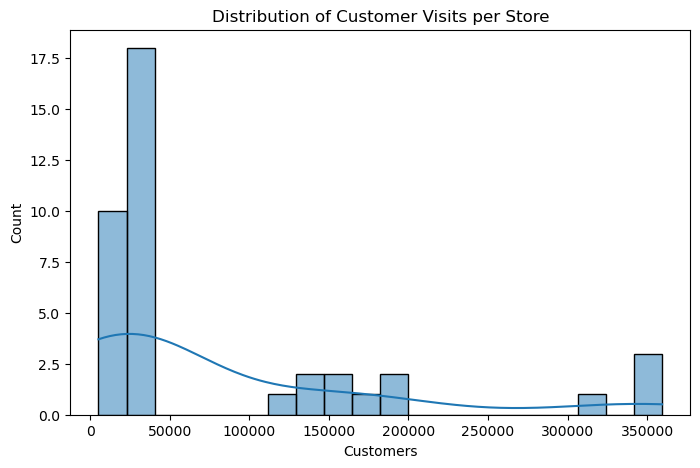

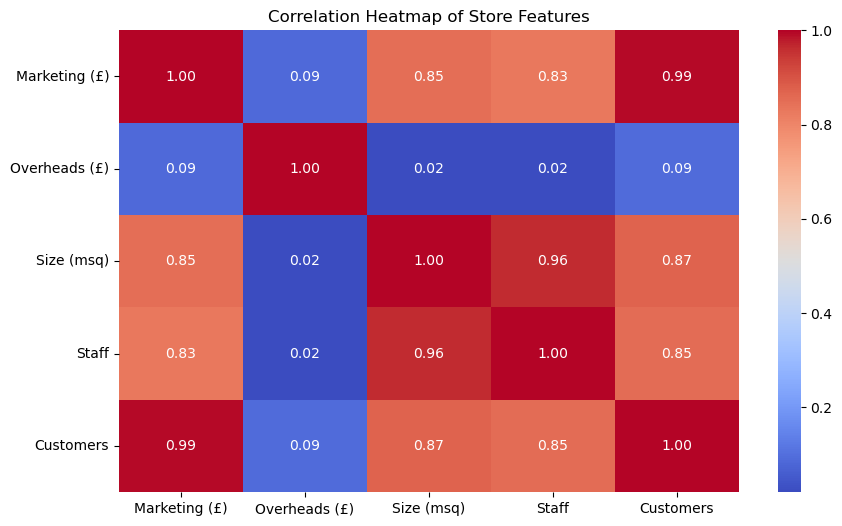

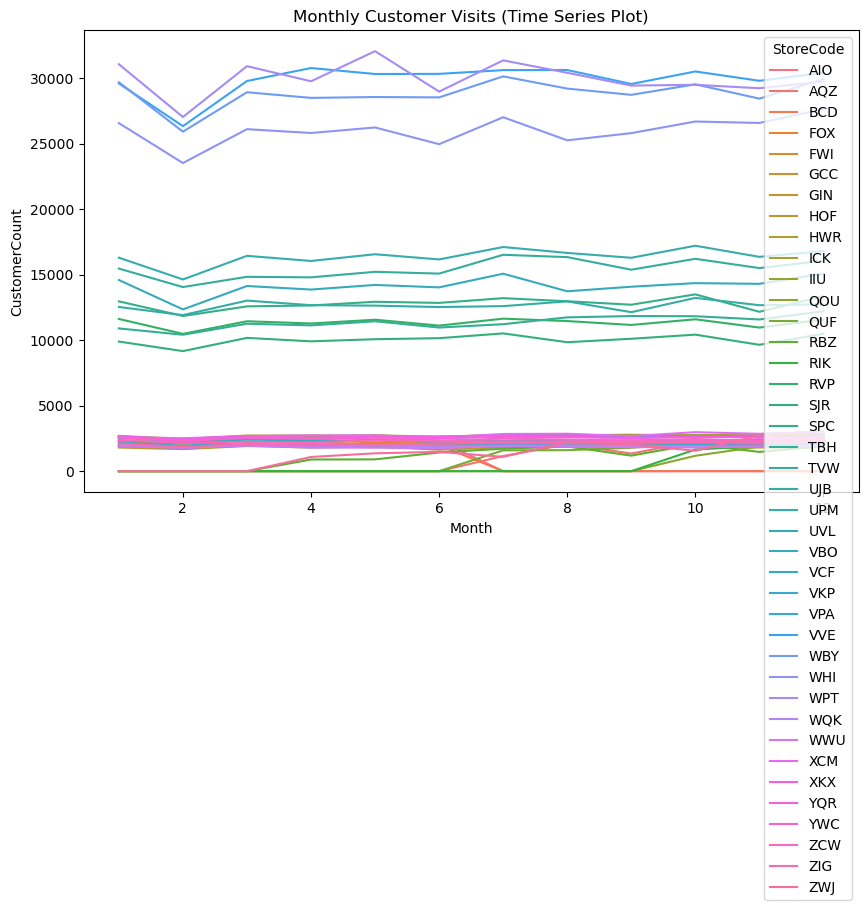

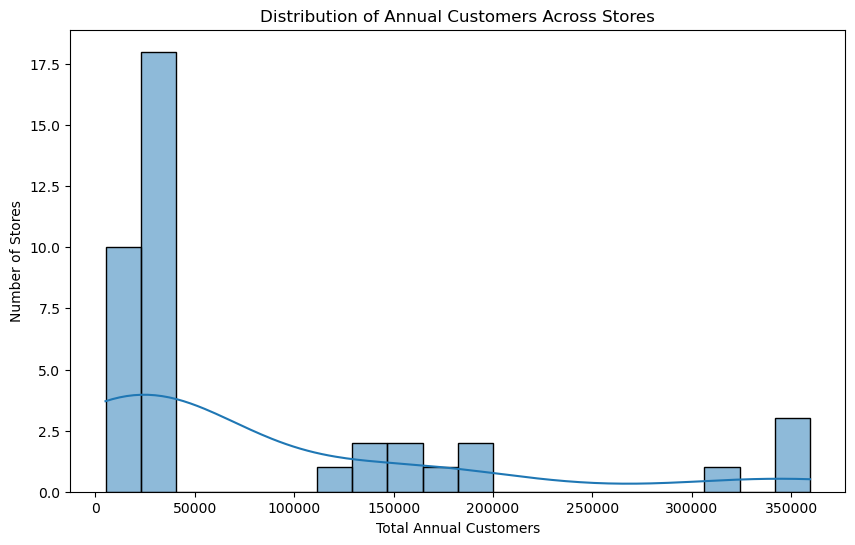

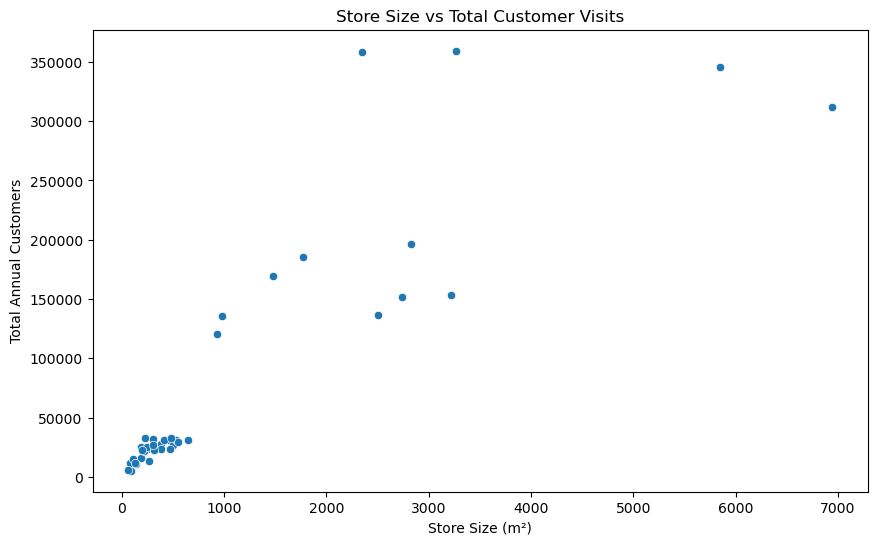

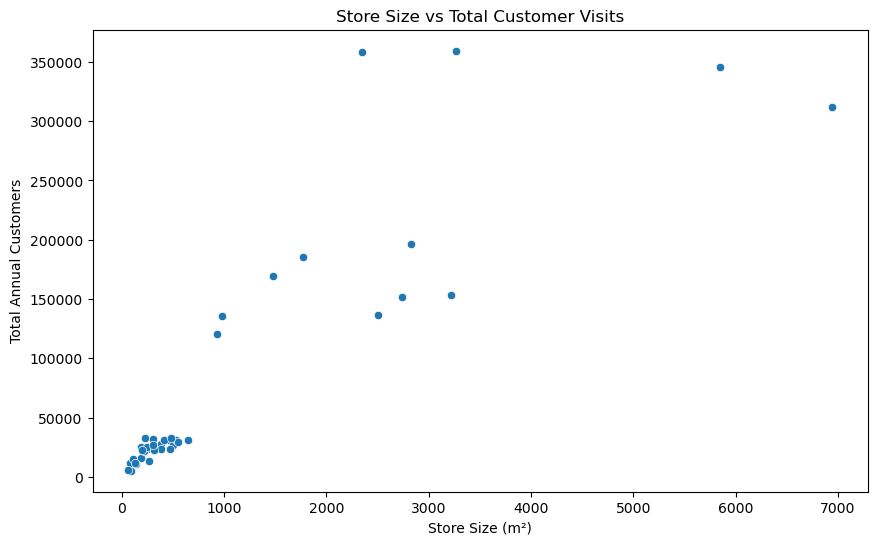

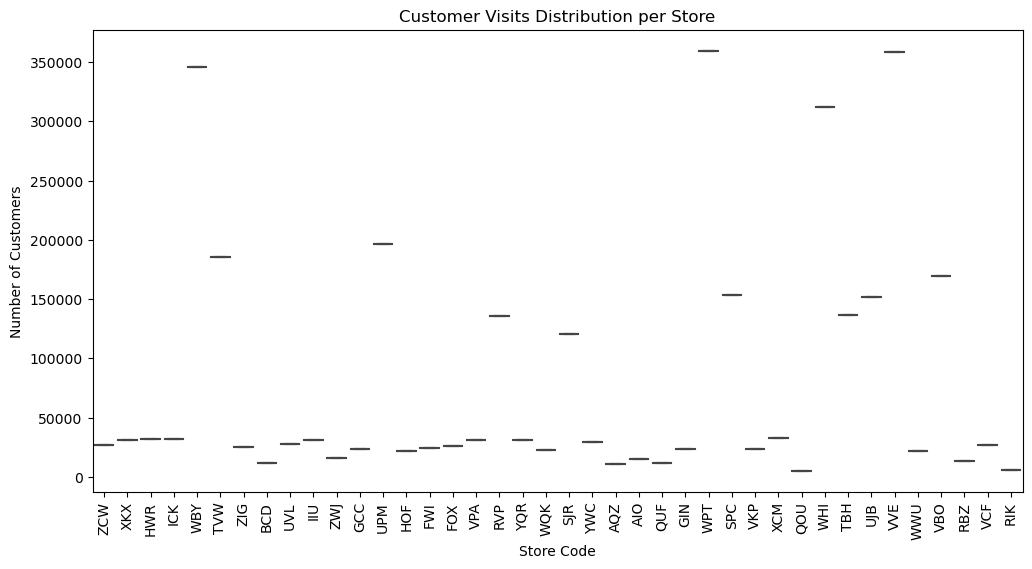

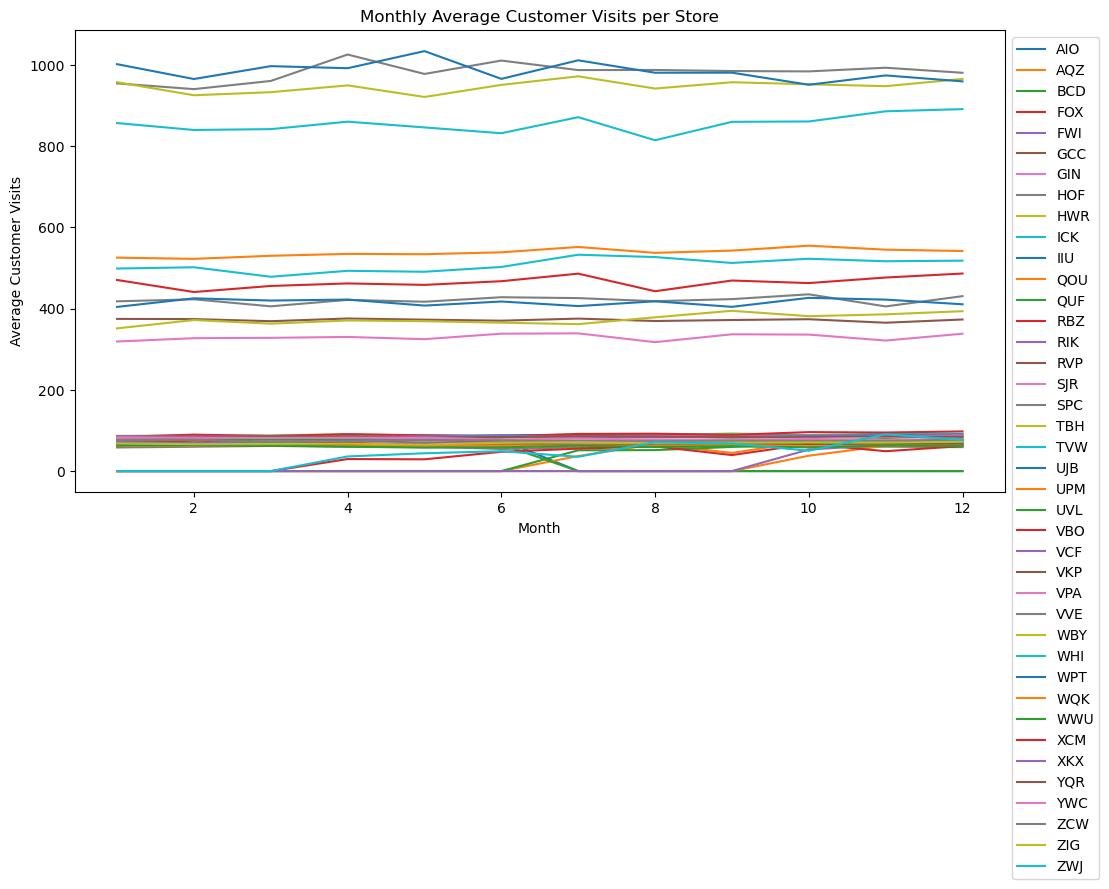

Newly opened stores: ['AQZ', 'QOU', 'QUF', 'RBZ', 'RIK', 'ZWJ']
Closed stores: ['AIO', 'BCD']
Very low activity stores: ['QOU', 'RIK']


Newly opened stores: ['AQZ', 'QOU', 'QUF', 'RBZ', 'RIK', 'ZWJ']
Closed stores: ['AIO', 'BCD']
Very low activity stores: ['QOU', 'RIK']


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os
import requests
from io import StringIO

# List of required file URLs
required_files = {
    "StoreDailyCustomers.csv": "https://raw.githubusercontent.com/ChrisWalshaw/DataViz/master/Data/001403755/StoreDailyCustomers.csv",
    "StoreMarketing.csv": "https://raw.githubusercontent.com/ChrisWalshaw/DataViz/master/Data/001403755/StoreMarketing.csv",
    "StoreOverheads.csv": "https://raw.githubusercontent.com/ChrisWalshaw/DataViz/master/Data/001403755/StoreOverheads.csv",
    "StoreSize.csv": "https://raw.githubusercontent.com/ChrisWalshaw/DataViz/master/Data/001403755/StoreSize.csv",
    "StoreStaff.csv": "https://raw.githubusercontent.com/ChrisWalshaw/DataViz/master/Data/001403755/StoreStaff.csv"
}

# Function to load CSV from URL
def load_csv_from_url(url):
    response = requests.get(url)
    if response.status_code == 200:
        df = pd.read_csv(StringIO(response.text))
        df.columns = df.columns.str.strip()  # Remove leading/trailing spaces from column names
        return df
    else:
        raise FileNotFoundError(f"Failed to retrieve {url}, status code: {response.status_code}")

# Load datasets
cust_data = load_csv_from_url(required_files["StoreDailyCustomers.csv"])
marketing_data = load_csv_from_url(required_files["StoreMarketing.csv"])
overheads_data = load_csv_from_url(required_files["StoreOverheads.csv"])
size_data = load_csv_from_url(required_files["StoreSize.csv"])
staff_data = load_csv_from_url(required_files["StoreStaff.csv"])

# Ensure 'Store' column exists and rename if necessary
def ensure_store_column(df, df_name, alternative_name=None):
    possible_names = [col for col in df.columns if 'store' in col.lower()]
    if not possible_names and alternative_name and alternative_name in df.columns:
        df.rename(columns={alternative_name: 'Store'}, inplace=True)
        return df
    elif not possible_names:
        raise KeyError(f"Missing 'Store' column in {df_name} dataset. Available columns: {df.columns.tolist()}")
    if possible_names[0] != 'Store':
        df.rename(columns={possible_names[0]: 'Store'}, inplace=True)
    return df

# Validate and rename columns
marketing_data = ensure_store_column(marketing_data, "Marketing", alternative_name="Id")
overheads_data = ensure_store_column(overheads_data, "Overheads", alternative_name="Id")
size_data = ensure_store_column(size_data, "Size", alternative_name="Id")
staff_data = ensure_store_column(staff_data, "Staff", alternative_name="Id")

# Transform customer data to long format
cust_data = cust_data.melt(id_vars=["Date"], var_name="Store", value_name="Customers")

# Merge datasets into summary dataframe
summary_data = marketing_data.merge(overheads_data, on='Store')
summary_data = summary_data.merge(size_data, on='Store')
summary_data = summary_data.merge(staff_data, on='Store')

# Aggregate customer data per store
customer_summary = cust_data.groupby('Store')["Customers"].sum().reset_index()
summary_data = summary_data.merge(customer_summary, on='Store')

# Convert numeric columns to float (excluding 'Store')
numeric_columns = [col for col in summary_data.columns if summary_data[col].dtype != 'O']
summary_data[numeric_columns] = summary_data[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Exploratory Data Analysis (EDA)
print(summary_data.describe())

# Visualization 1: Distribution of Customer Visits
plt.figure(figsize=(8, 5))
sns.histplot(summary_data['Customers'], bins=20, kde=True)
plt.title("Distribution of Customer Visits per Store")
plt.show()

# Visualization 2: Correlation Heatmap
plt.figure(figsize=(10, 6))
numeric_summary = summary_data.select_dtypes(include=['number'])
sns.heatmap(numeric_summary.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap of Store Features")
plt.show()

# Visualization 3: Monthly Customer Visits (Time Series Plot)

# --- Prepare monthly customer data ---
monthly_customer_data = cust_data.copy()  # Start with customer data
monthly_customer_data['Date'] = pd.to_datetime(monthly_customer_data['Date'])  # Convert 'Date' to datetime
monthly_customer_data['Month'] = monthly_customer_data['Date'].dt.month  # Extract month
monthly_customer_data = monthly_customer_data.groupby(['Store', 'Month'])['Customers'].sum().reset_index()  # Group by store and month
monthly_customer_data.rename(columns={'Store': 'StoreCode', 'Customers': 'CustomerCount'}, inplace=True)  # Rename columns to match plot

plt.figure(figsize=(10, 6))
# numeric_summary = summary_data.select_dtypes(include=['number'])  # This line is not needed for this plot
sns.lineplot(data=monthly_customer_data, x='Month', y='CustomerCount', hue='StoreCode')
plt.title("Monthly Customer Visits (Time Series Plot)")
plt.show()

# Visualization 4: Histogram of Customer Visits per Store (Annual Total)
total_customers = cust_data.groupby('Store')['Customers'].sum() # Use cust_data instead of StoreDailyCustomers and correct column names
plt.figure(figsize=(10, 6))
sns.histplot(total_customers, bins=20, kde=True)
plt.xlabel('Total Annual Customers')
plt.ylabel('Number of Stores')
plt.title('Distribution of Annual Customers Across Stores')
plt.show()

# Visualization 5: Store Size vs Total Customer Visits (Scatter Plot)
# Use 'cust_data' instead of 'store_daily_customers' and rename columns for consistency
store_total_customers = cust_data.groupby('Store')['Customers'].sum().reset_index()
# The 'Store' column is already present, no need to rename it to 'StoreCode'
# store_total_customers.rename(columns={'Store': 'StoreCode', 'Customers': 'DailyCustomers'}, inplace=True)
store_total_customers.rename(columns={'Customers': 'DailyCustomers'}, inplace=True) # Only rename 'Customers' to 'DailyCustomers'


# Change 'StoreCode' to 'Store' in size_data selection to match the actual column name
# The original code was trying to access 'Size' but the column is named 'Size (msq)'
store_summary = size_data[['Store', 'Size (msq)']].merge(store_total_customers, on='Store')  # Assuming 'store_size' was meant to be 'size_data'
# Since we are using 'Store' as the merge key, no need to rename it to 'StoreCode' here
# store_summary.rename(columns={'Store': 'StoreCode'}, inplace=True) # Rename to StoreCode for consistency with other visualizations if needed


plt.figure(figsize=(10, 6))
# Change 'Size' to 'Size (msq)' in the scatterplot function as well
sns.scatterplot(x='Size (msq)', y='DailyCustomers', data=store_summary)
plt.xlabel('Store Size (m²)')
plt.ylabel('Total Annual Customers')
plt.title('Store Size vs Total Customer Visits')
plt.show()

plt.figure(figsize=(10, 6))
# Change 'Size' to 'Size (msq)' in the scatterplot function as well
sns.scatterplot(x='Size (msq)', y='DailyCustomers', data=store_summary)
plt.xlabel('Store Size (m²)')
plt.ylabel('Total Annual Customers')
plt.title('Store Size vs Total Customer Visits')
plt.show()

#Visualization 6: Boxplot of Customer Visits per Store
plt.figure(figsize=(12, 6))
# Use 'store_summary' instead of 'store_daily_customers'
# Use 'Store' for x-axis and 'DailyCustomers' for y-axis
sns.boxplot(x='Store', y='DailyCustomers', data=store_summary)
plt.xlabel('Store Code')
plt.ylabel('Number of Customers')
plt.title('Customer Visits Distribution per Store')
plt.xticks(rotation=90)
plt.show()
#Visualization 7: Line Plot of Monthly Average Customer Visits (for each Store)
# The 'store_daily_customers' variable was not defined. Replace it with 'cust_data'.
cust_data['Date'] = pd.to_datetime(cust_data['Date'])
cust_data['Month'] = cust_data['Date'].dt.month
# 'StoreCode' and 'DailyCustomers' columns do not exist in 'cust_data'.
# Replace with 'Store' and 'Customers'.
monthly_avg_visits = cust_data.groupby(['Store', 'Month'])['Customers'].mean().reset_index()

plt.figure(figsize=(12, 6))
# Replace 'StoreCode' with 'Store' to match the groupby.
for store in monthly_avg_visits['Store'].unique():
    store_data = monthly_avg_visits[monthly_avg_visits['Store'] == store]
    # Replace 'DailyCustomers' with 'Customers' to match the groupby.
    plt.plot(store_data['Month'], store_data['Customers'], label=store)
plt.xlabel('Month')
plt.ylabel('Average Customer Visits')
plt.title('Monthly Average Customer Visits per Store')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()
# visualization 8 
import pandas as pd
import matplotlib.pyplot as plt

# Convert customer data to a pivot table: rows = Date, columns = Store, values = Customers
pivoted_data = cust_data.pivot_table(index='Date', columns='Store', values='Customers')
pivoted_data.index = pd.to_datetime(pivoted_data.index)
pivoted_data.sort_index(inplace=True)

# Function to identify store changes
def identify_store_status(data):
    first_window = data.head(30).sum()
    last_window = data.tail(30).sum()

    new = list(data.columns[(first_window == 0) & (last_window > 0)])
    closed = list(data.columns[(first_window > 0) & (last_window == 0)])
    low = list(data.columns[data.sum() < data.sum().quantile(0.05)])

    return new, closed, low

# Run store status detection
new_stores, closed_stores, low_activity_stores = identify_store_status(pivoted_data)

# Display findings
print("Newly opened stores:", new_stores)
print("Closed stores:", closed_stores)
print("Very low activity stores:", low_activity_stores)

# Visualise changes if any
if new_stores or closed_stores:
    fig, ax = plt.subplots(figsize=(14, 7))

    for store in new_stores:
        ax.plot(pivoted_data.index, pivoted_data[store], label=f"New: {store}")
    for store in closed_stores:
        ax.plot(pivoted_data.index, pivoted_data[store], label=f"Closed: {store}")

    ax.set(title="Customer Trends for New and Closed Stores", xlabel="Date", ylabel="Customers")
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()
#Visualization 8 customers trends for new and closed stores.
import pandas as pd
import matplotlib.pyplot as plt

# Convert customer data to a pivot table: rows = Date, columns = Store, values = Customers
pivoted_data = cust_data.pivot_table(index='Date', columns='Store', values='Customers')
pivoted_data.index = pd.to_datetime(pivoted_data.index)
pivoted_data.sort_index(inplace=True)

# Function to identify store changes
def identify_store_status(data):
    first_window = data.head(30).sum()
    last_window = data.tail(30).sum()

    new = list(data.columns[(first_window == 0) & (last_window > 0)])
    closed = list(data.columns[(first_window > 0) & (last_window == 0)])
    low = list(data.columns[data.sum() < data.sum().quantile(0.05)])

    return new, closed, low

# Run store status detection
new_stores, closed_stores, low_activity_stores = identify_store_status(pivoted_data)

# Display findings
print("Newly opened stores:", new_stores)
print("Closed stores:", closed_stores)
print("Very low activity stores:", low_activity_stores)

# Visualise changes if any
if new_stores or closed_stores:
    fig, ax = plt.subplots(figsize=(14, 7))

    for store in new_stores:
        ax.plot(pivoted_data.index, pivoted_data[store], label=f"New: {store}")
    for store in closed_stores:
        ax.plot(pivoted_data.index, pivoted_data[store], label=f"Closed: {store}")

    ax.set(title="Customer Trends for New and Closed Stores", xlabel="Date", ylabel="Customers")
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()
